# Mean-Reversion Strategy Based on Bollinger Bands

A mean-reversion strategy (MRS) is based on the principle that financial instruments can be overbought (overpriced) or oversold (underpriced) and the price of the instrument reverts back to its mean. A useful indicator in this strategy is _Bollinger bands_ constructed using a simple moving average, upper and lower bands (typically) at +/-2 standard deviations away from the average.

The signals to look for are:
| Signal | Action |
| --- | --- |
| Price < Lower band | Long position |
| Price crosses moving average | Neutral position
| Price > Upper band | Short position |

In this notebook, we will apply this strategy to the EUR/USD rates.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utilities as ut

### Explore data

In [2]:
ticker = "EURUSD=X"
start = "2004-01-01"
end = "2024-12-31"
df = ut.get_data(ticker, start=start, end=end)
df = ut.get_logreturns(df=df)

[*********************100%***********************]  1 of 1 completed


In [3]:
df.head()

,Price,Log Returns
Date,,
2004-01-01,1.258194,NaN
2004-01-02,1.258194,0.000000
2004-01-05,1.268698,0.008313
2004-01-06,1.272103,0.002681
2004-01-07,1.264095,-0.006315


In [4]:
window = 30
df["Moving Average"] = df["Price"].rolling(window).mean()
df["Moving Std"] = df["Price"].rolling(window).std()
df["Lower Band"] = df["Moving Average"] - 2*df["Moving Std"]
df["Upper Band"] = df["Moving Average"] + 2*df["Moving Std"]
df.dropna(inplace=True)

Text(0.5, 1.0, 'Price data with Bollinger bands')

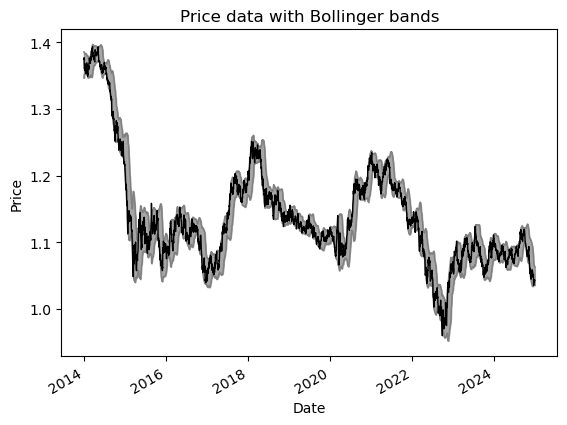

In [5]:
# plot last ten years for better view
df["Price"].loc["2014":].plot(c='k',lw=1,zorder=3)
df["Lower Band"].loc["2014":].plot(c='grey',lw=1)
df["Upper Band"].loc["2014":].plot(c='grey',lw=1)
plt.fill_between(df.index[df.index>="2014"],y1=df["Lower Band"].loc["2014":],y2=df["Upper Band"].loc["2014":],color='grey',alpha=.7)
plt.ylabel("Price")
plt.title('Price data with Bollinger bands')

In [6]:
df.head()

,Price,Log Returns,Moving Average,Moving Std,Lower Band,Upper Band
Date,,,,,,
2004-02-11,1.283005,0.011367,1.261227,0.013176,1.234875,1.287578
2004-02-12,1.281805,-0.000936,1.262014,0.013684,1.234646,1.289381
2004-02-13,1.272799,-0.007051,1.262501,0.013802,1.234896,1.290105
2004-02-16,1.276503,0.002906,1.262761,0.013995,1.234770,1.290752
2004-02-17,1.285793,0.007251,1.263217,0.014524,1.234169,1.292265


### Mean reverting strategy

In [7]:
df["Price - MA"] = df["Price"] - df["Moving Average"] # distance to moving average
df["Position"] = np.where(df["Price"] < df["Lower Band"], 1, np.nan)
df["Position"] = np.where(df["Price"] > df["Upper Band"], -1, df["Position"])
df["Position"] = np.where((df["Price - MA"] * df["Price - MA"].shift(1)) < 0, 0, df["Position"])
df["Position"] = df["Position"].ffill().fillna(0) # if there are no crossings, retain the previous position

Text(0.5, 1.0, 'Price data with Bollinger bands')

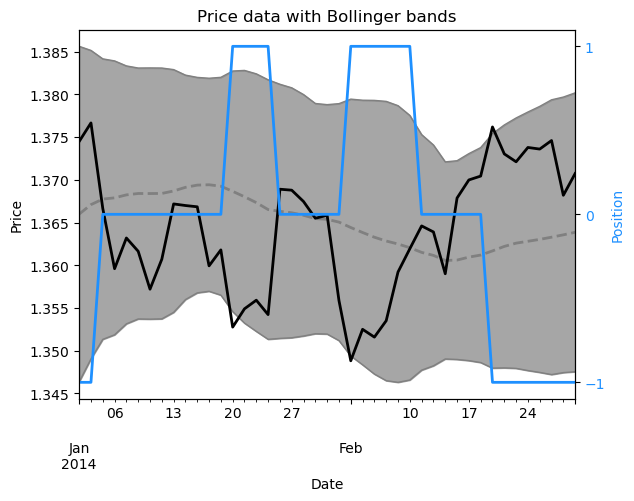

In [8]:
df["Price"].loc["01-2014":"02-2014"].plot(c='k',lw=2, zorder=3, label="Price")
df["Lower Band"].loc["01-2014":"02-2014"].plot(c='grey', lw=1)
df["Upper Band"].loc["01-2014":"02-2014"].plot(c='grey', lw=1)
df["Moving Average"].loc["01-2014":"02-2014"].plot(c='grey', ls='--', lw=2)
plt.fill_between(df.index[(df.index>="01-2014") & (df.index<="03-2014")], y1=df["Lower Band"].loc["01-2014":"02-2014"], y2=df["Upper Band"].loc["01-2014":"02-2014"],color='grey',alpha=.7)
plt.ylabel("Price")

ax2 = plt.gca().twinx()
df["Position"].loc["01-2014":"02-2014"].plot(c='dodgerblue', lw=2)
plt.ylabel("Position", color='dodgerblue')
plt.yticks([-1,0,1], color='dodgerblue')

plt.title('Price data with Bollinger bands')

### Include trading costs

Now let us consider the effect of including trading costs by assuming that the proportional trading cost (PTC) is 0.00007. In practice, the PTC will change over time and also depends on how the broker levies trading costs.

In [9]:
ptc = 7e-5
df["# Trades"] = df["Position"].diff().fillna(0).abs()
df["# Trades"].value_counts()

0.0    5127
1.0     293
Name: # Trades, dtype: int64

### Backtesting

In [10]:
df["Returns MRS"] = df["Position"].shift(1) * df["Log Returns"]
df["Returns MRS (after costs)"] = df["Returns MRS"] - df["# Trades"] * ptc
df.dropna(inplace=True)

Text(0, 0.5, 'Wealth / Investment')

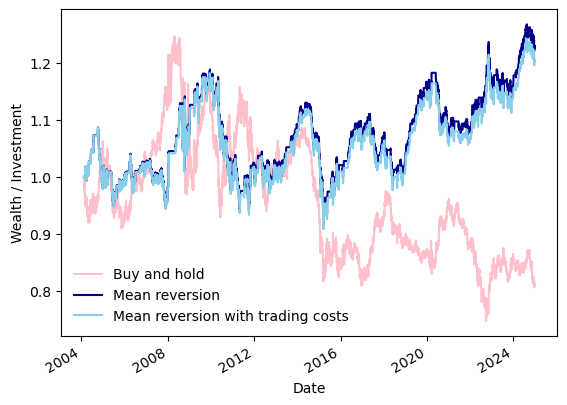

In [11]:
df["Log Returns"].cumsum().apply(np.exp).plot(label='Buy and hold', c='pink')
df["Returns MRS"].cumsum().apply(np.exp).plot(label='Mean reversion', c='darkblue')
df["Returns MRS (after costs)"].cumsum().apply(np.exp).plot(label='Mean reversion with trading costs', c='skyblue')
plt.legend(frameon=0)
plt.ylabel("Wealth / Investment")

Despite trading costs, the mean-reverting strategy is more profitable than buy-and-hold.

#### Effect of averaging window

We examine the performance of MRS for different averaging windows using buy-and-hold as benchmark.

[*********************100%***********************]  1 of 1 completed


Text(0, 0.5, 'Overperformance w.r.t. buy-and-hold')

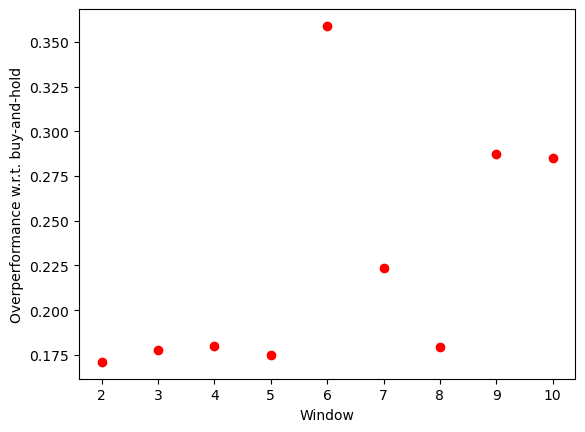

In [13]:
windows = range(2,11)
df_raw = ut.get_data(ticker, start=start, end=end)
df_raw = ut.get_logreturns(df=df_raw)

def overperformance(data, window, ptc=7e-5):
    
    data["Moving Average"] = data["Price"].rolling(window).mean()
    data["Moving Std"] = data["Price"].rolling(window).std()
    # print(data.info())
    data["Lower Band"] = data["Moving Average"] - 2*data["Moving Std"]
    data["Upper Band"] = data["Moving Average"] + 2*data["Moving Std"]
    data.dropna(inplace=True)
    data["Price - MA"] = data["Price"] - data["Moving Average"] # distance to moving average
    data["Position"] = np.where(data["Price"] < data["Lower Band"], 1, np.nan)
    data["Position"] = np.where(data["Price"] > data["Upper Band"], -1, data["Position"])
    data["Position"] = np.where((data["Price - MA"] * data["Price - MA"].shift(1)) < 0, 0, data["Position"])
    data["Position"] = data["Position"].ffill().fillna(0) # if there are no crossings, retain the previous position
    data["# Trades"] = data["Position"].diff().fillna(0).abs()
    data["Returns MRS (after costs)"] = data["Position"].shift(1) * data["Log Returns"] - data["# Trades"] * ptc
    data.dropna(inplace=True)
    return data["Returns MRS (after costs)"].cumsum().apply(np.exp)[-1] - data["Log Returns"].cumsum().apply(np.exp)[-1]

performance = []
for window in windows:
    performance.append(overperformance(df_raw.copy(), window))
plt.plot(windows, performance, 'ro')
plt.xlabel("Window")
plt.ylabel("Overperformance w.r.t. buy-and-hold")